In [1]:
# pip install shap

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier, MLPRegressor

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer

from sklearn.metrics import (
        classification_report, confusion_matrix, r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, accuracy_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve
) 

from sklearn.inspection import PartialDependenceDisplay, permutation_importance, partial_dependence

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, RepeatedStratifiedKFold
from xgboost import XGBClassifier, XGBRegressor, plot_importance
from sklearn.model_selection import cross_val_score

In [5]:
from category_encoders import TargetEncoder 
from sklearn.feature_selection import SelectFromModel

In [6]:
# from sklearn.datasets import make_classification

In [7]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [8]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer 

In [9]:
from feature_engine.imputation import CategoricalImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor

In [10]:
from xgbimputer import XGBImputer

In [11]:
import tqdm as notebook_tqdm

In [12]:
import shap

In [13]:
TrainPre2019 = pd.read_csv('../data/Pre2019_df_Cat9999999.csv')

/var/folders/nl/hqcw9pqd0ns4q0b61syv0q2m0000gn/T/ipykernel_39057/2282598049.py:1: DtypeWarning: Columns (17,41,44) have mixed types. Specify dtype option on import or set low_memory=False.
  TrainPre2019 = pd.read_csv('../data/Pre2019_df_Cat9999999.csv')


In [14]:
TrainPre2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 949528 entries, 0 to 949527
Data columns (total 53 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Unnamed: 0.1                    949528 non-null  int64  
 1   Unnamed: 0                      949528 non-null  int64  
 2   RecordID                        949528 non-null  int64  
 3   ESS_Id                          949528 non-null  int64  
 4   EventTimeStamp                  949528 non-null  object 
 5   eventDescription                902364 non-null  object 
 6   actionDescription               0 non-null       float64
 7   ecuSoftwareVersion              747330 non-null  object 
 8   ecuSerialNumber                 707932 non-null  object 
 9   ecuModel                        900949 non-null  object 
 10  ecuMake                         900949 non-null  object 
 11  ecuSource                       949528 non-null  int64  
 12  spn             

**Goal:** Predict the rank based on the total shots.

In [15]:
TrainPre2019['time_interval_to_SPN5246_class'].value_counts()

time_interval_to_SPN5246_class
9999999    718718
0          227503
1            1935
3             837
2             535
Name: count, dtype: int64

In [16]:
TrainPre2019

,Unnamed: 0.1,Unnamed: 0,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,...,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,spn_fmi,is_fullderate,is_fullderate_group,EquipID_Index,time_to_next_SPN5246,time_interval_to_SPN5246_class
0,43931,48303,49415,2363162,2015-05-11 13:11:20,Incorrect Data J1939 Network #1 Primary Vehicl...,NaN,unknown,unknown,unknown,...,4.475814,3276.75,14.4,0.58,639.0_2.0,0,0,301_0,1.027800e+04,0
1,45693,50251,51363,2400445,2015-05-13 08:22:32,Condition Exists Cruise Control Enable Switch,NaN,unknown,unknown,unknown,...,64.637170,3276.75,89.6,4.64,596.0_31.0,0,0,301_0,1.023481e+04,0
2,50271,55260,57330,2482983,2015-05-18 09:34:05,Abnormal Rate of Change Aftertreatment 1 Outle...,NaN,PC4__1284P4C_2*,6U13D13,MX,...,63.525490,3276.75,0.0,20.30,3226.0_10.0,0,0,301_0,1.011362e+04,0
3,54326,59636,61706,2554027,2015-05-21 13:57:35,Incorrect Data J1939 Network #1 Primary Vehicl...,NaN,unknown,unknown,unknown,...,4.364162,3276.75,12.0,1.45,639.0_2.0,0,0,301_0,1.003723e+04,0
4,54418,59731,61801,2555325,2015-05-21 14:54:32,Incorrect Data J1939 Network #1 Primary Vehicl...,NaN,unknown,unknown,unknown,...,NaN,NaN,NaN,NaN,639.0_2.0,0,0,301_0,1.003628e+04,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
949523,4036,4494,4495,1052146,2015-02-24 16:24:05,Low (Severity Medium) Catalyst Tank Level,NaN,05317106*04119044*051914190353*09400015*G1*BDR*,79751302,6X1u13D1500000000,...,NaN,NaN,NaN,NaN,1761.0_18.0,0,0,R1762_0,2.400000e+08,9999999
949524,5907,6438,6439,1089561,2015-02-26 13:12:11,NaN,NaN,05317106*04119044*051914190353*09400015*G1*BDR*,79751302,6X1u13D1500000000,...,2.058292,3276.75,0.0,0.29,5848.0_9.0,0,0,R1762_0,2.400000e+08,9999999
949525,5915,6446,6447,1090499,2015-02-26 13:50:59,NaN,NaN,05317106*04119044*051914190353*09400015*G1*BDR*,79751302,6X1u13D1500000000,...,NaN,NaN,NaN,NaN,5848.0_9.0,0,0,R1762_0,2.400000e+08,9999999
949526,4472,4952,4953,1059704,2015-02-25 06:08:43,Incorrect Data J1939 Network #1 Primary Vehicl...,NaN,unknown,unknown,unknown,...,4.378725,3276.75,0.0,1.74,639.0_2.0,0,0,R1764_0,2.400000e+08,9999999


In [17]:
TrainPre2019[['ecuSource', 'LampStatus', 'time_interval_to_SPN5246_class', 'ecuSerialNumber', 'ecuModel', 'ecuMake']] = TrainPre2019[['ecuSource', 'LampStatus', 'time_interval_to_SPN5246_class', 'ecuSerialNumber', 'ecuModel', 'ecuMake']].astype('category')

In [18]:
TrainPre2019[['activeTransitionCount']] = TrainPre2019[['activeTransitionCount']].astype('int')

In [19]:
TrainPre2019.replace(to_replace='3276,75', value='3278.75', inplace=True)

In [20]:
TrainPre2019[[  'AcceleratorPedal',
                    'BarometricPressure',
                    'CruiseControlSetSpeed',
                    'DistanceLtd',
                    'EngineCoolantTemperature',
                    'EngineLoad',
                    'EngineOilPressure',
                    'EngineOilTemperature',
                    'EngineRpm',
                    'EngineTimeLtd',
                    'FuelLevel',
                    'FuelLtd',
                    'FuelRate',
                    'FuelTemperature',
                    'IntakeManifoldTemperature',
                    'Speed',
                    'Throttle',
                    'active',
                    'TurboBoostPressure',
                    'CruiseControlActive',
                    'IgnStatus',
                    'ParkingBrake',
                    'SwitchedBatteryVoltage'
]] = TrainPre2019[[                         'AcceleratorPedal',
                                            'BarometricPressure',
                                            'CruiseControlSetSpeed',
                                            'DistanceLtd',
                                            'EngineCoolantTemperature',
                                            'EngineLoad',
                                            'EngineOilPressure',
                                            'EngineOilTemperature',
                                            'EngineRpm',
                                            'EngineTimeLtd',
                                            'FuelLevel',
                                            'FuelLtd',
                                            'FuelRate',
                                            'FuelTemperature',
                                            'IntakeManifoldTemperature',
                                            'Speed',
                                            'Throttle',
                                            'active',
                                            'TurboBoostPressure',
                                            'CruiseControlActive',
                                            'IgnStatus',
                                            'ParkingBrake',
                                            'SwitchedBatteryVoltage'
                     ]].astype('float64')

In [21]:
NumericColumns = TrainPre2019.select_dtypes(include=[np.number]).columns.tolist()
NumericColumns_Without_MatchID = NumericColumns.pop(0)
NumericColumns

['Unnamed: 0',
 'RecordID',
 'ESS_Id',
 'actionDescription',
 'spn',
 'fmi',
 'active',
 'activeTransitionCount',
 'faultValue',
 'MCTNumber',
 'Latitude',
 'Longitude',
 'FaultId',
 'AcceleratorPedal',
 'BarometricPressure',
 'CruiseControlActive',
 'CruiseControlSetSpeed',
 'DistanceLtd',
 'EngineCoolantTemperature',
 'EngineLoad',
 'EngineOilPressure',
 'EngineOilTemperature',
 'EngineRpm',
 'EngineTimeLtd',
 'FuelLevel',
 'FuelLtd',
 'FuelRate',
 'FuelTemperature',
 'IgnStatus',
 'IntakeManifoldTemperature',
 'ParkingBrake',
 'ServiceDistance',
 'Speed',
 'SwitchedBatteryVoltage',
 'Throttle',
 'TurboBoostPressure',
 'is_fullderate',
 'is_fullderate_group',
 'time_to_next_SPN5246']

In [22]:
NonNumericColumns = TrainPre2019.select_dtypes(exclude=[np.number]).columns.tolist()
NonNumericColumns

['EventTimeStamp',
 'eventDescription',
 'ecuSoftwareVersion',
 'ecuSerialNumber',
 'ecuModel',
 'ecuMake',
 'ecuSource',
 'EquipmentID',
 'LocationTimeStamp',
 'LampStatus',
 'spn_fmi',
 'EquipID_Index',
 'time_interval_to_SPN5246_class']

In [23]:
X = TrainPre2019.drop(columns = [   'Unnamed: 0',
                                    'Unnamed: 0.1',
                                    'RecordID',
                                    'ESS_Id',
                                    'actionDescription',
                                    'spn',
                                    'fmi',
                                    'faultValue',
                                    'MCTNumber',
                                    'Latitude',
                                    'Longitude',
                                    'is_fullderate',
                                    'is_fullderate_group',
                                    'time_to_next_SPN5246',
                                    'ServiceDistance',
                                    'EventTimeStamp',
                                    'eventDescription',
                                    'EquipmentID',
                                    'LocationTimeStamp',
                                    'EquipID_Index',
                                    'time_interval_to_SPN5246_class',
                                    'MCTNumber',                                  
                                    'FaultId',
                                    'ecuSoftwareVersion',
                                    'ecuSerialNumber',
                                    'ecuModel',
                                    'ecuMake'                                                                                      
                                ]
                      )
y = TrainPre2019['time_interval_to_SPN5246_class']

In [24]:
X['spn_fmi'] = X['spn_fmi'].str.replace('.0', '')

In [25]:
X

,ecuSource,active,activeTransitionCount,AcceleratorPedal,BarometricPressure,CruiseControlActive,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,...,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,spn_fmi
0,11,1.0,127,14.4,13.9200,0.0,0.00000,120841.70,185.0,18.0,...,134.6,1.0,154.4,1279.0,0.0,4.475814,3276.75,14.4,0.58,639_2
1,49,1.0,3,89.6,14.4275,0.0,0.00000,121687.10,186.8,38.0,...,100.4,1.0,120.2,4351.0,0.0,64.637170,3276.75,89.6,4.64,596_31
2,0,1.0,6,0.0,14.3550,0.0,0.00000,123057.10,185.0,0.0,...,120.2,1.0,118.4,17407.0,0.0,63.525490,3276.75,0.0,20.30,3226_10
3,11,1.0,127,12.0,14.5725,0.0,0.00000,124496.50,183.2,14.0,...,109.4,1.0,107.6,1279.0,0.0,4.364162,3276.75,12.0,1.45,639_2
4,11,0.0,127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1279.0,NaN,NaN,NaN,NaN,NaN,639_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
949523,0,0.0,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1023.0,NaN,NaN,NaN,NaN,NaN,1761_18
949524,0,1.0,1,0.0,14.2100,0.0,66.48672,80838.70,134.6,11.0,...,32.0,1.0,84.2,17407.0,0.0,2.058292,3276.75,0.0,0.29,5848_9
949525,0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1023.0,NaN,NaN,NaN,NaN,NaN,5848_9
949526,11,1.0,127,21.6,14.4275,0.0,66.48672,83681.85,154.4,12.0,...,32.0,1.0,93.2,1279.0,0.0,4.378725,3276.75,0.0,1.74,639_2


In [26]:
y

0               0
1               0
2               0
3               0
4               0
           ...   
949523    9999999
949524    9999999
949525    9999999
949526    9999999
949527    9999999
Name: time_interval_to_SPN5246_class, Length: 949528, dtype: category
Categories (5, int64): [0, 1, 2, 3, 9999999]

In [27]:
X.describe()

,active,activeTransitionCount,AcceleratorPedal,BarometricPressure,CruiseControlActive,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,...,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,ParkingBrake,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure
count,949528.000000,949528.000000,426247.000000,476659.000000,466508.000000,467458.000000,476568.000000,476625.000000,476168.000000,476735.000000,...,476017.000000,475932.000000,248414.000000,494185.000000,476730.000000,303591.000000,475134.000000,102624.000000,320557.000000,474652.000000
mean,0.520453,77.236872,28.544902,14.191954,0.096682,62.174458,364626.882789,169.566761,31.959878,33.453187,...,50560.896556,4.627839,37.043151,0.995724,106.750817,0.283948,26.293766,3104.761359,66.074916,6.286150
std,0.499582,59.230868,36.550423,1.195484,0.295525,12.239142,142701.441105,32.811442,30.635726,11.282650,...,24171.307050,5.783522,23.152840,0.065249,25.476308,0.450913,28.208800,729.139651,46.345526,8.557188
min,0.000000,0.000000,0.000000,3.045000,0.000000,0.000000,0.000000,-7.600000,0.000000,0.000000,...,0.000000,0.000000,17.600000,0.000000,-40.000000,0.000000,0.000000,7.650000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,14.210000,0.000000,64.622600,267338.900000,170.600000,11.000000,28.420000,...,33494.638645,0.647223,32.000000,1.000000,89.600000,0.000000,0.000000,3276.750000,0.000000,0.580000
50%,1.000000,126.000000,4.000000,14.355000,0.000000,66.486720,379825.250000,183.200000,19.000000,36.540000,...,51938.602972,1.690706,32.000000,1.000000,109.400000,0.000000,9.699216,3276.750000,100.000000,2.030000
75%,1.000000,126.000000,48.800000,14.500000,0.000000,66.486720,481544.650000,186.800000,48.000000,39.440000,...,68751.040705,7.211920,32.000000,1.000000,125.600000,1.000000,59.933190,3276.750000,100.000000,8.700000
max,1.000000,127.000000,100.000000,15.225000,1.000000,69.593570,649549.000000,406.400000,101.000000,145.000000,...,312737.574126,25.611560,231.800000,1.000000,264.200000,1.000000,158.447200,3278.750000,100.000000,63.220000


In [28]:
X

le_y = LabelEncoder()

y_fitted = le_y.fit(y)
y_encoded = le_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size = 0.001, random_state = 321, shuffle=True, stratify = y_encoded)


In [ ]:
 

ct0 = ColumnTransformer(
        [('target_encoder', TargetEncoder(handle_unknown='ignore'), ['spn_fmi',
                                                                        'ecuSource',
                                                                        'LampStatus'
                                                                    ]
          )],
        remainder='passthrough')
        



xgbc_pipe = Pipeline(
    steps=[
        ('preprocessor0', ct0),
        ('StandardScaler', StandardScaler()),
        ('imputer', IterativeImputer(estimator = HistGradientBoostingRegressor(verbose=2, random_state=434), max_iter=100, random_state=343)),
        ('smote', SMOTE(random_state=344)),
        ('xgbc', XGBClassifier( enable_categorical=True, 
                                eval_metric='mlogloss',
                                objective = 'multi:softmax',
                                num_class = 5,
                                device = "cuda",
                                random_state = 535                         
                            )
        )
    ]
).fit(X_train, y_train) 

y_pred = xgbc_pipe.predict(X_test)  





Binning 0.178 GB of training data: 0.370 s
Binning 0.020 GB of validation data: 0.028 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.44866, val loss: 0.44669, in 0.070s
[2/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.40619, val loss: 0.40481, in 0.057s
[3/100] 1 tree, 31 leaves, max depth = 7, train loss: 0.37158, val loss: 0.37073, in 0.068s
[4/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.34348, val loss: 0.34301, in 0.069s
[5/100] 1 tree, 31 leaves, max depth = 7, train loss: 0.32028, val loss: 0.32023, in 0.051s
[6/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.30132, val loss: 0.30164, in 0.086s
[7/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.28575, val loss: 0.28644, in 0.059s
[8/100] 1 tree, 31 leaves, max depth = 7, train loss: 0.27244, val loss: 0.27332, in 0.050s
[9/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.26172, val loss: 0.26283, in 0.092s
[10/100] 1 tree, 31 leaves, max depth = 9, train lo

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/bentonwang/Library/Python/3.13/lib/python/site-packages/xgboost/training.py:183: UserWarning: [12:39:21] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


In [30]:
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {root_mean_squared_error(y_test, y_pred)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, y_pred)}')
print(f'R2: {r2_score(y_test, y_pred)}')

MSE: 3.225263157894737
RMSE: 1.7959017673288082
MAE: 0.8378947368421052
MAPE: 1327376732277619.8
R2: -0.1029563610776294


In [31]:
le_y

LabelEncoder()

In [32]:
y_fitted

LabelEncoder()

In [33]:
y_encoded

array([0, 0, 0, ..., 4, 4, 4], shape=(949528,))

In [34]:
y

0               0
1               0
2               0
3               0
4               0
           ...   
949523    9999999
949524    9999999
949525    9999999
949526    9999999
949527    9999999
Name: time_interval_to_SPN5246_class, Length: 949528, dtype: category
Categories (5, int64): [0, 1, 2, 3, 9999999]

In [35]:
accuracy_score(y_test, y_pred)

0.7778947368421053

In [36]:
confusion_matrix(y_test, y_pred)

array([[156,   2,   1,   0,  69],
       [  0,   2,   0,   0,   0],
       [  0,   0,   0,   0,   0],
       [  0,   0,   0,   1,   0],
       [104,  30,   5,   0, 580]])

In [37]:
print(classification_report(y_test, y_pred, zero_division = 0))

              precision    recall  f1-score   support

           0       0.60      0.68      0.64       228
           1       0.06      1.00      0.11         2
           2       0.00      0.00      0.00         0
           3       1.00      1.00      1.00         1
           4       0.89      0.81      0.85       719

    accuracy                           0.78       950
   macro avg       0.51      0.70      0.52       950
weighted avg       0.82      0.78      0.80       950



cv = LeaveOneOut()
scores = cross_val_score(xgbc_pipe, X_test, y_test, cv=10, scoring='recall_macro')

print('Cross Validation Macro Precision Scores:', scores)

### Import fresh test data (previously held out) for a fresh round of testing 

In [38]:
test = pd.read_csv('../data/In2019_df_Cat9999999.csv') 

In [39]:
FreshTest_In2019 = test
FreshTest_In2019

,Unnamed: 0.1,Unnamed: 0,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,...,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,spn_fmi,is_fullderate,is_fullderate_group,EquipID_Index,time_to_next_SPN5246,time_interval_to_SPN5246_class
0,952775,1062090,1104925,73930906,2019-01-11 12:51:18,High Voltage (Fuel Level),NaN,unknown,unknown,unknown,...,46.52031,NaN,34.4,13.05,96.0_3.0,0,1,301_1,239999976.0,9999999
1,952776,1062091,1104926,73930907,2019-01-11 12:51:18,High Voltage (Left Fuel Level Sensor),NaN,unknown,unknown,unknown,...,46.52031,NaN,34.4,13.05,829.0_3.0,0,1,301_1,239999976.0,9999999
2,952781,1062096,1104931,73934247,2019-01-11 13:11:40,High Voltage (Fuel Level),NaN,unknown,unknown,unknown,...,NaN,NaN,NaN,NaN,96.0_3.0,0,1,301_1,239999976.0,9999999
3,952782,1062097,1104932,73934248,2019-01-11 13:11:40,High Voltage (Left Fuel Level Sensor),NaN,unknown,unknown,unknown,...,NaN,NaN,NaN,NaN,829.0_3.0,0,1,301_1,239999976.0,9999999
4,952809,1062135,1104970,73942005,2019-01-11 13:13:38,High Voltage (Fuel Level),NaN,unknown,unknown,unknown,...,0.00000,NaN,0.0,1.16,96.0_3.0,0,1,301_1,239999976.0,9999999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112014,977126,1089938,1137548,80503703,2019-03-16 11:22:32,Incorrect Data J1939 Network #1 Primary Vehicl...,NaN,AAAI000051*AAAM010056*Z091290 *A82J170202A_b...,6232171647,EC80ESP,...,NaN,NaN,NaN,NaN,639.0_2.0,0,0,105437340_0,239999976.0,9999999
112015,977150,1089962,1137572,80509396,2019-03-16 11:24:04,Special Instructions Engine Starter Solenoid L...,NaN,5569997 *E250.e003*,K1243673,FAOM-xx810S-EC3,...,0.00000,NaN,100.0,0.29,1321.0_14.0,0,0,105437340_0,239999976.0,9999999
112016,977151,1089963,1137573,80509397,2019-03-16 11:27:41,NaN,NaN,5569997 *E250.e003*,K1243673,FAOM-xx810S-EC3,...,0.00000,NaN,100.0,0.29,520321.0_13.0,0,0,105437340_0,239999976.0,9999999
112017,978491,1091502,1139112,80907838,2019-03-20 10:57:34,Special Instructions Engine Starter Solenoid L...,NaN,NaN,K1243673,FAOM-xx810S-EC3,...,NaN,NaN,NaN,NaN,1321.0_14.0,0,0,105437340_0,239999976.0,9999999


In [40]:
FreshTest_In2019[['ecuSource', 'LampStatus', 'time_interval_to_SPN5246_class', 'ecuSerialNumber', 'ecuModel', 'ecuMake']] = FreshTest_In2019[['ecuSource', 'LampStatus', 'time_interval_to_SPN5246_class', 'ecuSerialNumber', 'ecuModel', 'ecuMake']].astype('category')

In [41]:
FreshTest_In2019[['activeTransitionCount']] = FreshTest_In2019[['activeTransitionCount']].astype('int')

In [42]:
X_fresh_test = FreshTest_In2019.drop(columns = [    'Unnamed: 0',
                                                    'Unnamed: 0.1',
                                                    'RecordID',
                                                    'ESS_Id',
                                                    'actionDescription',
                                                    'spn',
                                                    'fmi',
                                                    'faultValue',
                                                    'MCTNumber',
                                                    'Latitude',
                                                    'Longitude',
                                                    'is_fullderate',
                                                    'is_fullderate_group',
                                                    'time_to_next_SPN5246',
                                                    'ServiceDistance',
                                                    'EventTimeStamp',
                                                    'eventDescription',
                                                    'EquipmentID',
                                                    'LocationTimeStamp',
                                                    'EquipID_Index',
                                                    'time_interval_to_SPN5246_class',
                                                    'MCTNumber',                                  
                                                    'FaultId',
                                                    'ecuSoftwareVersion',
                                                    'ecuSerialNumber',
                                                    'ecuModel',
                                                    'ecuMake'  
                                                    ]
                                     )  
X_fresh_test

,ecuSource,active,activeTransitionCount,AcceleratorPedal,BarometricPressure,CruiseControlActive,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,...,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,spn_fmi
0,49,True,126,34.0,14.5,False,0.0,389864.2,145.4,46.0,...,71.6,True,84.2,1279.0,False,46.52031,NaN,34.4,13.05,96.0_3.0
1,49,True,126,34.0,14.5,False,0.0,389864.2,145.4,46.0,...,71.6,True,84.2,1279.0,False,46.52031,NaN,34.4,13.05,829.0_3.0
2,49,False,126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,255.0,NaN,NaN,NaN,NaN,NaN,96.0_3.0
3,49,False,126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,255.0,NaN,NaN,NaN,NaN,NaN,829.0_3.0
4,49,True,126,0.0,14.5,False,0.0,389870.2,156.2,13.0,...,87.8,True,107.6,1279.0,True,0.00000,NaN,0.0,1.16,96.0_3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112014,11,False,127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,50175.0,NaN,NaN,NaN,NaN,NaN,639.0_2.0
112015,3,True,1,0.0,14.5,False,0.0,147893.8,82.4,25.0,...,NaN,True,68.0,63487.0,True,0.00000,NaN,100.0,0.29,1321.0_14.0
112016,3,True,4,0.0,14.5,False,0.0,147893.8,91.4,24.0,...,NaN,True,73.4,63487.0,True,0.00000,NaN,100.0,0.29,520321.0_13.0
112017,3,False,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,63487.0,NaN,NaN,NaN,NaN,NaN,1321.0_14.0


In [43]:
X_fresh_test['spn_fmi'] = X_fresh_test['spn_fmi'].str.replace('.0', '')

In [44]:
X_fresh_test.shape

(112019, 27)

X_FreshTest_Transformed = ct.transform(X_fresh_test)
X_FreshTest_Transformed

In [45]:
y_fresh_pred = xgbc_pipe.predict(X_fresh_test)

In [46]:
y_fresh_pred

array([0, 0, 4, ..., 4, 4, 4], shape=(112019,), dtype=int32)

In [47]:
y_fresh_test = FreshTest_In2019['time_interval_to_SPN5246_class']

In [48]:
y_fresh_test_encoded = le_y.transform(y_fresh_test)

In [49]:
accuracy_score(y_fresh_test_encoded, y_fresh_pred)

0.8813058499004633

In [50]:
confusion_matrix(y_fresh_test_encoded, y_fresh_pred)

array([[  109,   162,    64,     1,  1708],
       [   18,   144,    27,     0,   103],
       [    2,    24,     2,     0,    16],
       [    0,     0,     0,   100,     1],
       [ 7507,  2610,  1043,    10, 98368]])

In [51]:
print(classification_report(y_fresh_test_encoded, y_fresh_pred, zero_division = 0)) 

              precision    recall  f1-score   support

           0       0.01      0.05      0.02      2044
           1       0.05      0.49      0.09       292
           2       0.00      0.05      0.00        44
           3       0.90      0.99      0.94       101
           4       0.98      0.90      0.94    109538

    accuracy                           0.88    112019
   macro avg       0.39      0.50      0.40    112019
weighted avg       0.96      0.88      0.92    112019



In [ ]:
y_fresh_test_encoded.tolist()  

[4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,


In [53]:
y_fresh_pred.tolist()

[0,
 0,
 4,
 4,
 0,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 0,
 4,
 4,
 4,
 4,
 4,
 0,
 4,
 4,
 4,
 4,
 2,
 2,
 4,
 4,
 0,
 0,
 4,
 4,
 4,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 1,
 4,
 4,
 4,
 0,
 1,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 0,
 4,
 4,
 1,
 1,
 1,
 1,
 1,
 4,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 2,
 4,
 4,
 0,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 4,
 4,
 0,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 4,
 4,
 2,
 2,
 4,
 4,
 0,
 0,
 4,
 4,
 0,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 1,
 0,
 1,
 4,
 4,
 4,
 0,
 4,
 4,
 0,
 4,
 1,
 0,
 0,
 1,
 2,
 4,
 2,
 4,
 4,
 0,
 4,
 0,
 4,
 4,
 4,
 4,
 4,
 0,
 4,
 1,
 4,
 4,
 0,
 1,
 0,
 4,
 4,
 4,
 4,
 4,
 1,
 1,
 4,
 4,
 4,
 4,
 2,
 4,


In [54]:
print(f'MSE: {mean_squared_error(y_fresh_test_encoded, y_fresh_pred)}')
print(f'RMSE: {root_mean_squared_error(y_fresh_test_encoded, y_fresh_pred)}')
print(f'MAE: {mean_absolute_error(y_fresh_test_encoded, y_fresh_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(y_fresh_test_encoded, y_fresh_pred)}')
print(f'R2: {r2_score(y_fresh_test_encoded, y_fresh_pred)}') 

MSE: 1.5765896856783224
RMSE: 1.2556232260030564
MAE: 0.4239816459707728
MAPE: 286452720922475.56
R2: -4.068146506050027


fresh_cv = LeaveOneOut()
fresh_CV_scores = cross_val_score(xgbc_pipe, X_fresh_test, y_fresh_test_encoded, cv=10, scoring='recall_macro')

print('Cross Validation Macro Precision Scores:', fresh_CV_scores)

In [55]:
y_fresh_pred_series = pd.Series(y_fresh_pred)
y_fresh_pred_series

0         0
1         0
2         4
3         4
4         0
         ..
112014    4
112015    4
112016    4
112017    4
112018    4
Length: 112019, dtype: int32

In [56]:
In2019_withFresh_Y_Pred = pd.concat([FreshTest_In2019, y_fresh_pred_series], axis=1)
In2019_withFresh_Y_Pred.rename(columns={In2019_withFresh_Y_Pred.columns[-1]: 'Predicted_Time_Interval_Class'}, inplace=True)
In2019_withFresh_Y_Pred  

,Unnamed: 0.1,Unnamed: 0,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,...,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,spn_fmi,is_fullderate,is_fullderate_group,EquipID_Index,time_to_next_SPN5246,time_interval_to_SPN5246_class,Predicted_Time_Interval_Class
0,952775,1062090,1104925,73930906,2019-01-11 12:51:18,High Voltage (Fuel Level),NaN,unknown,unknown,unknown,...,NaN,34.4,13.05,96.0_3.0,0,1,301_1,239999976.0,9999999,0
1,952776,1062091,1104926,73930907,2019-01-11 12:51:18,High Voltage (Left Fuel Level Sensor),NaN,unknown,unknown,unknown,...,NaN,34.4,13.05,829.0_3.0,0,1,301_1,239999976.0,9999999,0
2,952781,1062096,1104931,73934247,2019-01-11 13:11:40,High Voltage (Fuel Level),NaN,unknown,unknown,unknown,...,NaN,NaN,NaN,96.0_3.0,0,1,301_1,239999976.0,9999999,4
3,952782,1062097,1104932,73934248,2019-01-11 13:11:40,High Voltage (Left Fuel Level Sensor),NaN,unknown,unknown,unknown,...,NaN,NaN,NaN,829.0_3.0,0,1,301_1,239999976.0,9999999,4
4,952809,1062135,1104970,73942005,2019-01-11 13:13:38,High Voltage (Fuel Level),NaN,unknown,unknown,unknown,...,NaN,0.0,1.16,96.0_3.0,0,1,301_1,239999976.0,9999999,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112014,977126,1089938,1137548,80503703,2019-03-16 11:22:32,Incorrect Data J1939 Network #1 Primary Vehicl...,NaN,AAAI000051*AAAM010056*Z091290 *A82J170202A_b...,6232171647,EC80ESP,...,NaN,NaN,NaN,639.0_2.0,0,0,105437340_0,239999976.0,9999999,4
112015,977150,1089962,1137572,80509396,2019-03-16 11:24:04,Special Instructions Engine Starter Solenoid L...,NaN,5569997 *E250.e003*,K1243673,FAOM-xx810S-EC3,...,NaN,100.0,0.29,1321.0_14.0,0,0,105437340_0,239999976.0,9999999,4
112016,977151,1089963,1137573,80509397,2019-03-16 11:27:41,NaN,NaN,5569997 *E250.e003*,K1243673,FAOM-xx810S-EC3,...,NaN,100.0,0.29,520321.0_13.0,0,0,105437340_0,239999976.0,9999999,4
112017,978491,1091502,1139112,80907838,2019-03-20 10:57:34,Special Instructions Engine Starter Solenoid L...,NaN,NaN,K1243673,FAOM-xx810S-EC3,...,NaN,NaN,NaN,1321.0_14.0,0,0,105437340_0,239999976.0,9999999,4


In [57]:
In2019_withFresh_Y_Pred.to_csv('../data/In2019_withFresh_Y_Pred_TimeIntervalClass.csv')

In [58]:
# submission.to_csv('../data/submission_XGBClassifier_TunedHyperparameter_TargetEncoder_LearningRatePt05_MaxTreeDepth5_MinChild1_Estimators199_TestSizePt001_MostFeatures_ExcludingMapCode.csv', index = False)

In [59]:
xgbc_pipe_XGBClassifier = xgbc_pipe[:-2]
xgbc_pipe_XGBClassifier

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor0',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('target_encoder',
                                                  TargetEncoder(handle_unknown='ignore'),
                                                  ['spn_fmi', 'ecuSource',
                                                   'LampStatus'])])),
                ('StandardScaler', StandardScaler()),
                ('imputer',
                 IterativeImputer(estimator=HistGradientBoostingRegressor(random_state=434,
                                                                          verbose=2),
                                  max_iter=1, random_state=343))])

In [60]:
X_fresh_test_transformed_SHAP = xgbc_pipe_XGBClassifier.transform(X_fresh_test)
X_fresh_test_transformed_SHAP  


array([[-0.32451552,  0.93834444,  0.71008788, ..., -2.54258758,
        -0.68355223,  0.79055376],
       [-0.09386109,  0.93834444,  0.71008788, ..., -2.54258758,
        -0.68355223,  0.79055376],
       [-0.32451552,  0.93834444,  0.99851596, ...,  0.24562152,
         0.490959  , -0.30119668],
       ...,
       [ 0.17136952,  0.60258214, -1.1790309 , ...,  0.43983271,
         0.73193247, -0.70069304],
       [ 1.37439052,  0.60258214, -1.1790309 , ...,  0.24412207,
         0.31343676, -0.30566724],
       [ 0.54132435,  0.60258214,  0.99851596, ...,  0.24790729,
         0.41136336, -0.30862111]], shape=(112019, 27))

In [61]:
explainer = shap.TreeExplainer(xgbc_pipe[4])
explanation = explainer(xgbc_pipe[:-2].transform(X_fresh_test))

In [62]:
explainer.shap_values(xgbc_pipe[:-2].transform(X_fresh_test))

array([[[-2.7540168e-01,  1.9972891e-01,  1.8630952e-01, -7.6352043e+00,
         -5.5749840e-01],
        [ 1.4716980e-01, -2.3152390e-01, -9.1763240e-01,  2.3475941e-01,
         -1.2600381e-02],
        [-1.2015821e-01, -1.6617589e-01,  2.8753164e-01,  2.6673409e-01,
         -3.1370129e-02],
        ...,
        [-1.7290752e-01,  9.7587854e-02,  1.9363550e-02,  1.3999684e-01,
         -9.3889602e-02],
        [ 4.8119944e-02, -1.3215525e-01,  1.6152716e-01,  4.9568415e-03,
         -3.3817416e-01],
        [-1.1784333e-02, -2.1480969e-01,  9.2844544e-03, -1.7986974e-01,
         -1.7765958e-03]],

       [[-2.7718210e-01, -3.0301917e-01, -1.4931621e-01, -7.6352043e+00,
         -5.2811134e-01],
        [ 1.4675702e-01, -1.9433117e-01, -7.7679521e-01,  2.3475941e-01,
         -1.3866422e-02],
        [-1.2615302e-01, -3.6316523e-01,  2.4378645e-01,  2.6673409e-01,
         -2.1658814e-02],
        ...,
        [-1.6975346e-01, -1.3904240e-03,  1.5309634e-02,  1.3999684e-01,
        

In [63]:
explanation[:,:,1]

.values =
array([[ 1.9972891e-01, -2.3152390e-01, -1.6617589e-01, ...,
         9.7587854e-02, -1.3215525e-01, -2.1480969e-01],
       [-3.0301917e-01, -1.9433117e-01, -3.6316523e-01, ...,
        -1.3904240e-03, -1.3302113e-01, -2.4688311e-01],
       [-4.5623686e-02, -3.9619836e-01, -1.9786359e-01, ...,
         1.8102508e-02,  3.4031864e-02,  8.9955144e-03],
       ...,
       [-6.1237687e-01,  2.4848323e-01,  1.4554709e-01, ...,
        -1.2657365e+00, -2.2400853e-01,  9.3595542e-02],
       [-9.0008199e-01,  7.2648294e-02,  1.9931203e-01, ...,
        -3.3514444e-02, -4.9046767e-01,  1.4745754e-02],
       [-6.0117382e-01,  1.4853974e-01,  4.7579188e-02, ...,
         9.4312773e-04,  7.0637502e-02,  4.3383534e-03]],
      shape=(112019, 27), dtype=float32)

.base_values =
array([0.49290133, 0.49290133, 0.49290133, ..., 0.49290133, 0.49290133,
       0.49290133], shape=(112019,), dtype=float32)

.data =
array([[-0.32451552,  0.93834444,  0.71008788, ..., -2.54258758,
        -0.683

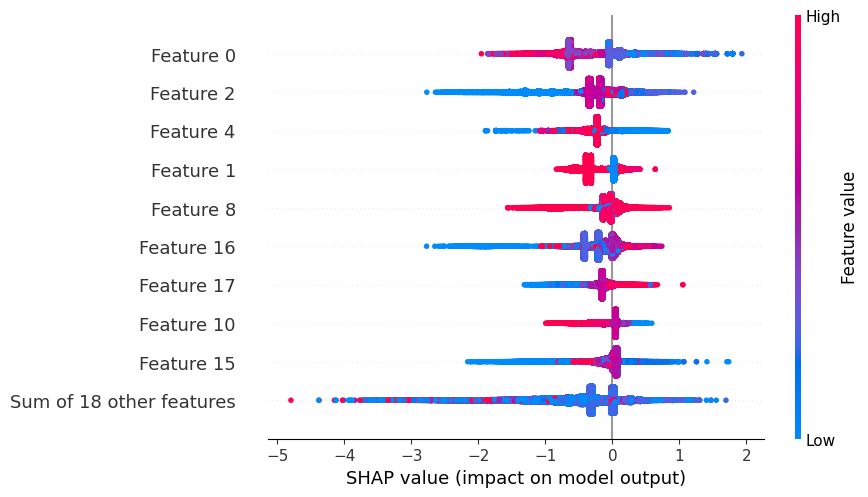

In [64]:
shap.plots.beeswarm(explanation[:,:,1])

In [73]:
xgbc_pipe[:-1].get_feature_names_out()[[0, 2, 4, 1, 8, 16, 17, 10, 15]].tolist()

['target_encoder__spn_fmi',
 'target_encoder__LampStatus',
 'remainder__activeTransitionCount',
 'target_encoder__ecuSource',
 'remainder__CruiseControlSetSpeed',
 'remainder__FuelLevel',
 'remainder__FuelLtd',
 'remainder__EngineCoolantTemperature',
 'remainder__EngineTimeLtd']

In [99]:
pd.DataFrame({'spn_fmi': X_fresh_test['spn_fmi'], 'SHAP_value':explanation[:,:,1].values[:,0]}).groupby('spn_fmi')['SHAP_value'].mean().sort_values(ascending = False)#[lambda x: x > 0]

spn_fmi
5571_6     1.360774
5114_9     1.297196
96_13      1.263799
5745_4     1.259045
5848_12    1.174674
             ...   
5246_19   -1.220521
4796_31   -1.258795
5246_16   -1.263104
4342_5    -1.347963
5246_0    -1.603088
Name: SHAP_value, Length: 533, dtype: float32

<Axes: xlabel='spn_fmi'>

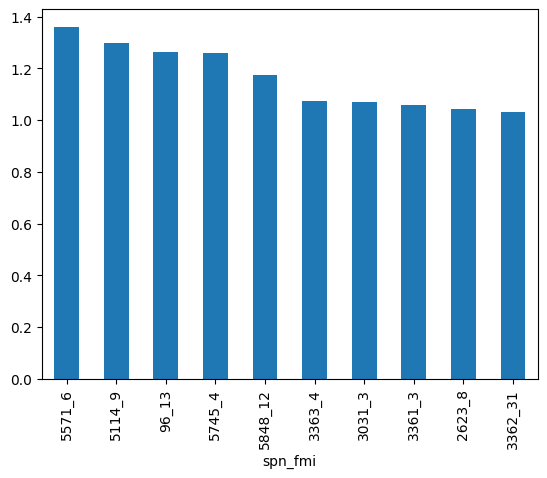

In [96]:
pd.DataFrame({'spn_fmi': X_fresh_test['spn_fmi'], 'SHAP_value':explanation[:,:,1].values[:,0]}).groupby('spn_fmi')['SHAP_value'].mean().sort_values(ascending = False)[lambda x: x > 0].head(10).plot(kind = 'bar')

In [ ]:
pd.DataFrame({'LampStatus': X_fresh_test['LampStatus'], 'SHAP_value':explanation[:,:,1].values[:,2]}).groupby('LampStatus')['SHAP_value'].mean().sort_values(ascending = False) #.plot(kind = 'bar') #[lambda x: x > 0]

/var/folders/nl/hqcw9pqd0ns4q0b61syv0q2m0000gn/T/ipykernel_39057/4279101998.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pd.DataFrame({'LampStatus': X_fresh_test['LampStatus'], 'SHAP_value':explanation[:,:,1].values[:,2]}).groupby('LampStatus')['SHAP_value'].mean().sort_values(ascending = False)#[lambda x: x > 0]


LampStatus
18431.0    0.439509
28436.0    0.292249
17407.0    0.115410
18419.0    0.113853
50175.0    0.035880
51199.0   -0.005783
22527.0   -0.009539
6143.0    -0.039411
55295.0   -0.052528
5119.0    -0.075944
2047.0    -0.082137
21503.0   -0.129135
63487.0   -0.130944
11801.0   -0.134680
65535.0   -0.168823
255.0     -0.211344
1279.0    -0.240234
62463.0   -1.026609
1023.0    -1.203026
2035.0    -1.303584
Name: SHAP_value, dtype: float32

/var/folders/nl/hqcw9pqd0ns4q0b61syv0q2m0000gn/T/ipykernel_39057/3735487212.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pd.DataFrame({'LampStatus': X_fresh_test['LampStatus'], 'SHAP_value':explanation[:,:,1].values[:,2]}).groupby('LampStatus')['SHAP_value'].mean().sort_values(ascending = False).plot(kind = 'bar')


<Axes: xlabel='LampStatus'>

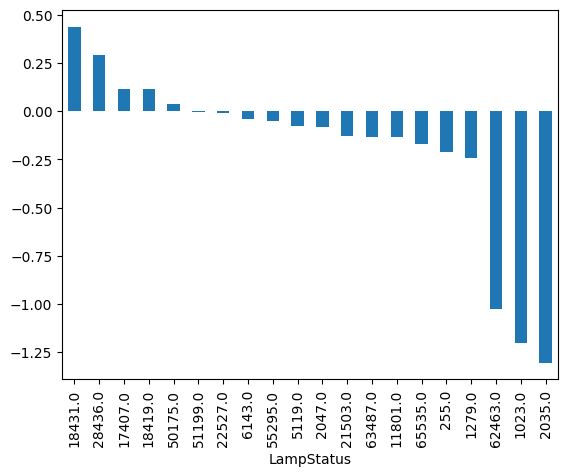

In [101]:
pd.DataFrame({'LampStatus': X_fresh_test['LampStatus'], 'SHAP_value':explanation[:,:,1].values[:,2]}).groupby('LampStatus')['SHAP_value'].mean().sort_values(ascending = False).plot(kind = 'bar')

In [84]:
explanation[:,:,1][0].values[0]

np.float32(0.1997289)

In [116]:
import seaborn as sns

In [118]:
FuelLevel_Exploration = pd.DataFrame({'FuelLevel': X_fresh_test['FuelLevel'], 'SHAP_value':explanation[:,:,1].values[:,4]})

<Axes: xlabel='FuelLevel', ylabel='SHAP_value'>

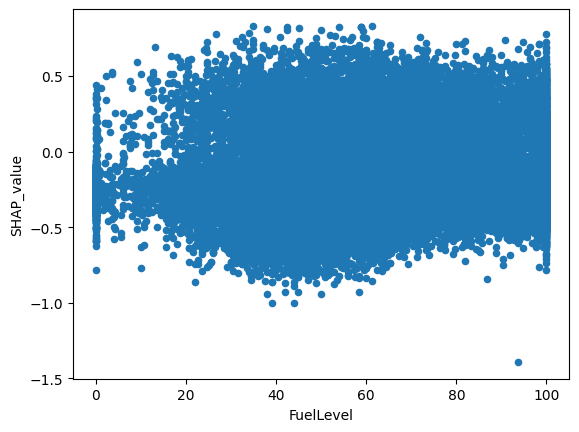

In [ ]:
pd.DataFrame({'FuelLevel': X_fresh_test['FuelLevel'], 'SHAP_value':explanation[:,:,1].values[:,4]}).plot(kind = 'scatter', x='FuelLevel', y='SHAP_value')

<Axes: xlabel='FuelLevel', ylabel='SHAP_value'>

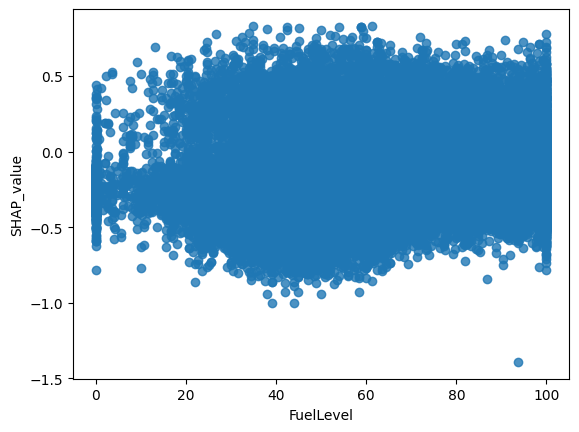

In [126]:
sns.regplot(data = FuelLevel_Exploration, x='FuelLevel', y='SHAP_value')

/var/folders/nl/hqcw9pqd0ns4q0b61syv0q2m0000gn/T/ipykernel_39057/2312108474.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pd.DataFrame({'ecuSource': X_fresh_test['ecuSource'], 'SHAP_value':explanation[:,:,1].values[:,1]}).groupby('ecuSource')['SHAP_value'].mean().sort_values(ascending = False).plot(kind = 'bar')


<Axes: xlabel='ecuSource'>

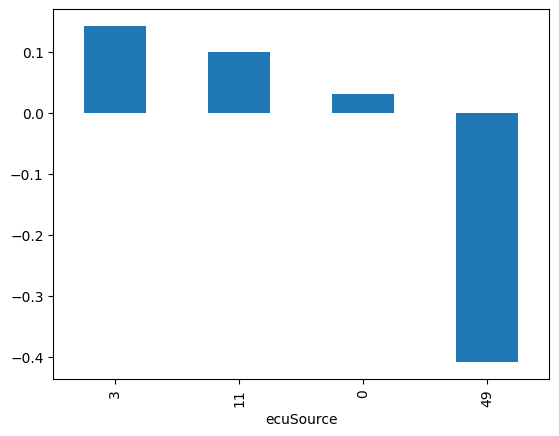

In [102]:
pd.DataFrame({'ecuSource': X_fresh_test['ecuSource'], 'SHAP_value':explanation[:,:,1].values[:,1]}).groupby('ecuSource')['SHAP_value'].mean().sort_values(ascending = False).plot(kind = 'bar')

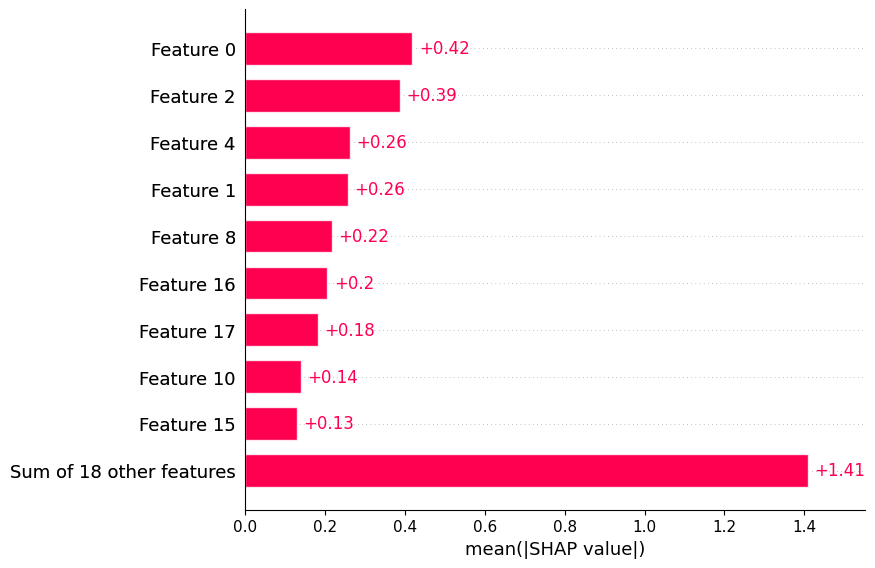

In [66]:
shap.plots.bar(explanation[:,:,1])

feature_names = xgbc_pipe[:-1].get_feature_names_out(input_features=X_fresh_test.columns)
feature_names

df_SHAP = pd.DataFrame(X_fresh_test_transformed_SHAP, columns=feature_names)
df_SHAP

In [67]:
xgbc_pipe[:-1].get_feature_names_out()[[0, 2, 16, 1, 8, 17, 3, 22, 7]].tolist()

['target_encoder__spn_fmi',
 'target_encoder__LampStatus',
 'remainder__FuelLevel',
 'target_encoder__ecuSource',
 'remainder__CruiseControlSetSpeed',
 'remainder__FuelLtd',
 'remainder__active',
 'remainder__ParkingBrake',
 'remainder__CruiseControlActive']

In [68]:
xgbc_pipe[:-1].get_feature_names_out()

array(['target_encoder__spn_fmi', 'target_encoder__ecuSource',
       'target_encoder__LampStatus', 'remainder__active',
       'remainder__activeTransitionCount', 'remainder__AcceleratorPedal',
       'remainder__BarometricPressure', 'remainder__CruiseControlActive',
       'remainder__CruiseControlSetSpeed', 'remainder__DistanceLtd',
       'remainder__EngineCoolantTemperature', 'remainder__EngineLoad',
       'remainder__EngineOilPressure', 'remainder__EngineOilTemperature',
       'remainder__EngineRpm', 'remainder__EngineTimeLtd',
       'remainder__FuelLevel', 'remainder__FuelLtd',
       'remainder__FuelRate', 'remainder__FuelTemperature',
       'remainder__IgnStatus', 'remainder__IntakeManifoldTemperature',
       'remainder__ParkingBrake', 'remainder__Speed',
       'remainder__SwitchedBatteryVoltage', 'remainder__Throttle',
       'remainder__TurboBoostPressure'], dtype=object)

# Top Features' Importance Quantification

In [69]:
selection = SelectFromModel(xgbc_pipe[4], threshold=0.0001, prefit=True)

In [70]:
X_selected = selection.transform(X_train) # xgbc_pipe[:-1].get_feature_names_out()
X_selected

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


array([[0, 1.0, 11, ..., 0.0, 11.02, '97_15'],
       [49, 1.0, 126, ..., 100.0, 0.29, '829_3'],
       [11, 0.0, 127, ..., nan, nan, '1068_2'],
       ...,
       [49, 0.0, 126, ..., nan, nan, '929_9'],
       [49, 0.0, 126, ..., nan, nan, '929_9'],
       [49, 1.0, 126, ..., 0.0, 0.58, '929_9']],
      shape=(948578, 27), dtype=object)

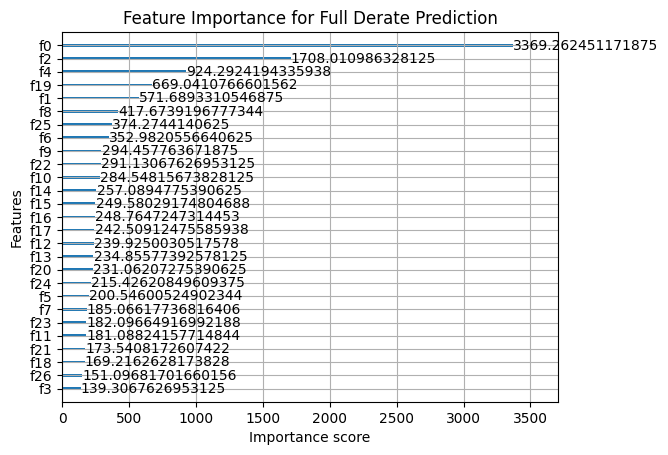

In [71]:
plot_importance_object = plot_importance(xgbc_pipe[4], importance_type='gain')
plt.title('Feature Importance for Full Derate Prediction')
plt.show()

In [82]:
feature_importances = xgbc_pipe[4].feature_importances_

feature_importance_df = pd.DataFrame({'Feature': xgbc_pipe[:-1].get_feature_names_out(), 'Importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

top_27_features = feature_importance_df.head(27)

print(top_27_features)

                                 Feature  Importance
0                target_encoder__spn_fmi    0.268285
2             target_encoder__LampStatus    0.136004
4       remainder__activeTransitionCount    0.073599
19            remainder__FuelTemperature    0.053274
1              target_encoder__ecuSource    0.045522
8       remainder__CruiseControlSetSpeed    0.033258
25                   remainder__Throttle    0.029802
6          remainder__BarometricPressure    0.028107
9                 remainder__DistanceLtd    0.023447
22               remainder__ParkingBrake    0.023182
10   remainder__EngineCoolantTemperature    0.022658
14                  remainder__EngineRpm    0.020471
15              remainder__EngineTimeLtd    0.019873
16                  remainder__FuelLevel    0.019808
17                    remainder__FuelLtd    0.019310
12          remainder__EngineOilPressure    0.019105
13       remainder__EngineOilTemperature    0.018701
20                  remainder__IgnStatus    0.

In [ ]:
print("Top 27 features:", top_27_features['Feature'].tolist())

Top 27 features: ['target_encoder__spn_fmi', 'target_encoder__LampStatus', 'remainder__activeTransitionCount', 'target_encoder__ecuSource', 'remainder__IgnStatus', 'remainder__EngineOilPressure', 'remainder__active', 'remainder__SwitchedBatteryVoltage', 'remainder__CruiseControlSetSpeed', 'remainder__DistanceLtd', 'remainder__FuelTemperature', 'remainder__BarometricPressure', 'remainder__EngineTimeLtd', 'remainder__FuelLtd', 'remainder__EngineCoolantTemperature', 'remainder__ParkingBrake', 'remainder__Throttle', 'remainder__Speed', 'remainder__EngineOilTemperature', 'remainder__TurboBoostPressure', 'remainder__FuelLevel', 'remainder__EngineRpm', 'remainder__EngineLoad', 'remainder__AcceleratorPedal', 'remainder__FuelRate', 'remainder__IntakeManifoldTemperature', 'remainder__CruiseControlActive']
